In [1]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import scipy
from scipy.stats import pearsonr
from bisect import bisect_left

In [6]:
# read the data
my_data = np.genfromtxt('DailyReturn.csv', delimiter=',').T
my_data = np.delete(my_data, 0, 0)
my_data = np.delete(my_data, 0, 1)
my_data = np.matrix(np.fliplr(my_data))

In [8]:
#Question 1 (a)

In [9]:
# calculate exponential weights
def exponential_weights_cal(lags, lamb):
    weights = []
    for i in range(1, lags + 1):
        weight = (1 - lamb) * lamb ** (i - 1)
        weights.append(weight)
    weights = np.array(weights)
    weights_normalize = weights / weights.sum()
    return weights_normalize

# calculate exponentially weighted covariance matrix
def weighted_cov(data, lamb):
    weights = exponential_weights_cal(data.shape[1], lamb)
    error_matrix = data - data.mean(axis=1)
    cov = error_matrix @ np.diag(weights) @ error_matrix.T
    return cov

In [10]:
#Question 1 (b)

In [19]:
# calculate the PCA cumulative explained variance ratio.
def PCA(cov_matrix):
    eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix)
    
    # sort eigen values and eigen vectors
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalues = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
    
    # calculate explained variance ratio
    evr = sorted_eigenvalues / sorted_eigenvalues.sum()
    cumulative_evr = evr.cumsum()
    cumulative_evr[-1] = 1
     
    return cumulative_evr

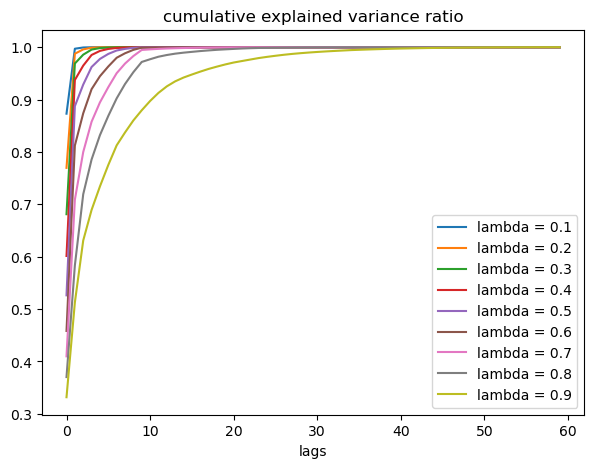

In [20]:
#plot
lambdas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

plt.figure(figsize=(7, 5))
for i, lamb in enumerate(lambdas):
    cov = weighted_cov(my_data, lamb)
    cumulative_evr = PCA(cov)
    plt.plot(np.arange(my_data.shape[1]), cumulative_evr[:my_data.shape[1]], label=f"lambda = {lambdas[i]}")

plt.xlabel('lags')
plt.title("cumulative explained variance ratio")
plt.legend()
plt.show()
     

In [21]:
#Question 2 

In [26]:
#copy chol_psd()
def chol_psd(root, a):
    n = a.shape[1]
    #loop over columns
    for j in range(n):
        s = 0.0
        #if we are not on the first column, calculate the dot product of the preceeding row values.
        if j > 0:
            s =  root[j,:j] @ root[j,:j].T
            
        # Diagonal Element
        temp = a[j,j] - s
        if -1e-8 <= temp <= 0:
            temp = 0.0
        root[j,j] = np.sqrt(temp)
        #Check for the 0 eigan value.  Just set the column to 0 if we have one
        if root[j,j] == 0.0:
            root[j,j:n-1] = 0.0
        else:
            #update off diagonal rows of the column
            for i in range(j+1, n):
                s = root[i,:j] @ root[j,:j].T
                root[i,j] = (a[i,j] - s) / root[j,j]
    return root

In [27]:
#copy near_psd()
def near_psd(a, epsilon=0.0):
    n = a.shape[1]
    invSD = None
    out = copy.deepcopy(a)
    # calculate the correlation matrix if we got a covariance
    if (np.sum(np.isclose(1.0, np.diag(out))) != n):
        invSD = np.diag(1.0 / np.sqrt(np.diag(out)))
        out = invSD @ out @ invSD
        
    # SVD, update the eigen value and scale
    vals, vecs = np.linalg.eigh(out)
    vals = np.maximum(vals, epsilon)
    T = 1.0 / (np.square(vecs) @ vals)
    T = np.diagflat(np.sqrt(T))
    l = np.diag(np.sqrt(vals))
    B = T @ vecs @ l
    out = B @ B.T
    
    # Add back the variance
    if invSD != None:
        invSD = np.diag(1.0 / np.diag(invSD))
        out = invSD @ out @ invSD
    return out

In [28]:
#Implement Higham’s 2002 nearest psd correlation function.
def frobenius_norm(matrix):
    return np.sqrt(np.square(matrix).sum())

def projection_u(matrix):
    out = copy.deepcopy(matrix)
    np.fill_diagonal(out, 1.0)
    return out

def projection_s(matrix, epsilon=0.0):
    vals, vecs = np.linalg.eigh(matrix)
    vals = np.maximum(vals, epsilon)
    return vecs @ np.diag(vals) @ vecs.T

# Higham
def higham_psd(a, max_iter=100, tol=1e-8):
    delta_s = 0.0
    y = a
    prev_gamma = np.inf

    for i in range(max_iter):
        r = y - delta_s
        x = projection_s(r)
        delta_s = x - r
        y = projection_u(x)
        gamma = frobenius_norm(y - a)
        if abs(gamma - prev_gamma) < tol:  
            break
        prev_gamma = gamma
        
    return y

In [30]:
#Confirm the matrix is now PSD
def is_psd(matrix, tol=1e-7):
    return np.all(np.linalg.eigvals(matrix) >= -tol)

#Generate a non-psd correlation matrix that is 500x500
n = 500
sigma = np.matrix(np.full((n, n), 0.9))
np.fill_diagonal(sigma, 1)
sigma[0, 1] = 0.7357
sigma[1, 0] = 0.7357

#print comfirm result
near_psd_matrix = near_psd(sigma)
print(is_psd(near_psd_matrix))
higham_psd_matrix = higham_psd(sigma)
print(is_psd(higham_psd_matrix))

True
True


In [31]:
#Compare the results of both using the Frobenius Norm
print(frobenius_norm(near_psd_matrix - sigma))
print(frobenius_norm(higham_psd_matrix - sigma))

0.6275226557656216
0.08964798746832911


In [32]:
#Compare run time
def generate_non_psd_matrix(n):
    sigma = np.matrix(np.full((n, n), 0.9))
    np.fill_diagonal(sigma, 1)
    sigma[0, 1] = 0.7357
    sigma[1, 0] = 0.7357
    return sigma

def near_psd_runtime(n):
    sigma = generate_non_psd_matrix(n)
    start_t = time.time()
    near_psd_matrix = near_psd(sigma)
    end_t = time.time()
    return end_t - start_t

def higham_psd_runtime(n):
    sigma = generate_non_psd_matrix(n)
    start_t = time.time()
    near_psd_matrix = higham_psd(sigma)
    end_t = time.time()
    return end_t - start_t

In [33]:
t1 = near_psd_runtime(100)
t2 = higham_psd_runtime(100)
print(t1)
print(t2)
print(t2 / t1)

0.002775907516479492
0.02106475830078125
7.588422227948123


In [34]:
t1 = near_psd_runtime(500)
t2 = higham_psd_runtime(500)
print(t1)
print(t2)
print(t2 / t1)

0.0510869026184082
0.41628170013427734
8.148501451412677


In [35]:
t1 = near_psd_runtime(900)
t2 = higham_psd_runtime(900)
print(t1)
print(t2)
print(t2 / t1)

0.14833307266235352
1.7244040966033936
11.625216586247134


In [36]:
#Question 3 (a)

In [37]:
# calculate correlation matrix
def calculate_corr(cov):
    std = np.sqrt(np.diag(cov))
    inversed_std = np.diag(1 / std)
    corr = inversed_std @ cov @ inversed_std
    return corr

# calculate covariance matrix
def calculate_cov(corr, var):
    std = np.diag(np.sqrt(var))
    cov = std @ corr @ std
    return cov

In [38]:
#Question 3 (b)

In [39]:
pearson_cov = np.cov(my_data)
pearson_var = np.diag(pearson_cov)
pearson_corr = calculate_corr(pearson_cov)
ew_cov = weighted_cov(my_data, 0.97)
ew_var = np.diag(ew_cov)
ew_corr = calculate_corr(ew_cov)
p_var_p_corr = calculate_cov(pearson_corr, pearson_var)
p_var_e_corr = calculate_cov(ew_corr, pearson_var)
e_var_p_corr = calculate_cov(pearson_corr, ew_var)
e_var_e_corr = calculate_cov(ew_corr, ew_var)
inputs = [p_var_p_corr, p_var_e_corr, e_var_p_corr, e_var_e_corr]

In [44]:
def direct_simulation(cov, n_samples=25000):
    root = np.full(cov.shape, 0.0)
    B = chol_psd(root, cov)
    r = np.random.randn(len(B[0]), n_samples)
    return B @ r

def pca_simulation(cov, pct_explained, n_samples=25000):
    eigen_values, eigen_vectors = np.linalg.eigh(cov)
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalues = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]

    evr = sorted_eigenvalues / sorted_eigenvalues.sum()
    cumulative_evr = evr.cumsum()
    cumulative_evr[-1] = 1

    idx = bisect_left(cumulative_evr, pct_explained)

    explained_vals = np.clip(sorted_eigenvalues[:idx + 1], 0, np.inf)
    explained_vecs = sorted_eigenvectors[:, :idx + 1]

    B = explained_vecs @ np.diag(np.sqrt(explained_vals))
    r = np.random.randn(B.shape[1], n_samples)
    return B @ r

<Figure size 640x480 with 0 Axes>

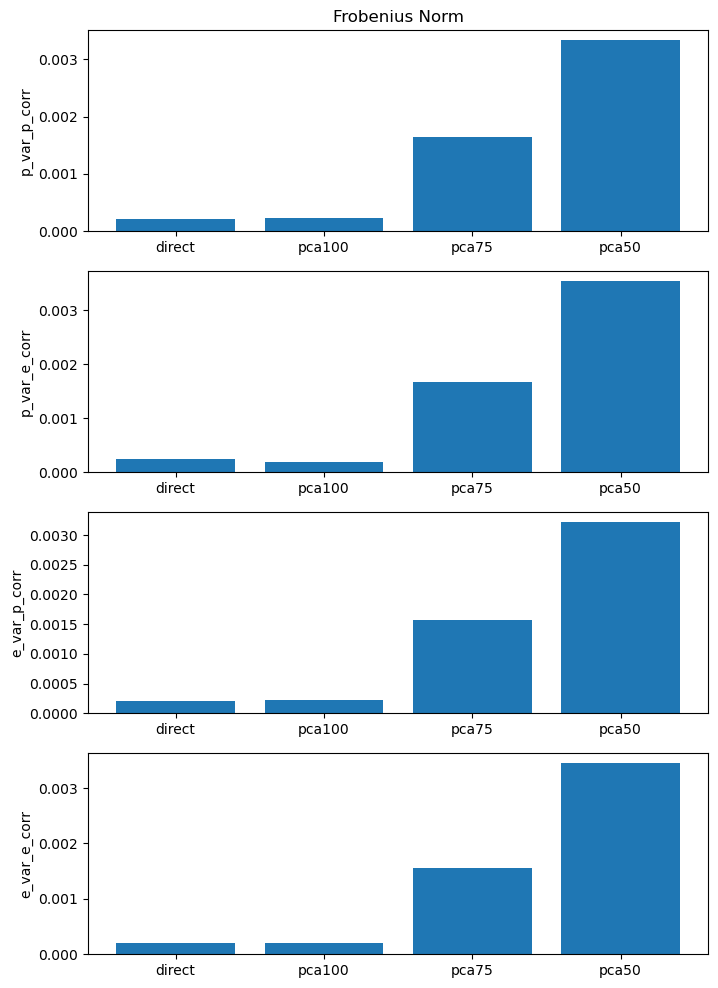

In [45]:
norm_d = []
norm_pca100 = []
norm_pca75 = []
norm_pca50 = []
time_d = []
time_pca100 = []
time_pca75 = []
time_pca50 = []

for cov in inputs:
    t0 = time.time()
    res_d = direct_simulation(cov)
    t1 = time.time()
    res_pca100 = pca_simulation(cov, 1)
    t2 = time.time()
    res_pca75 = pca_simulation(cov, 0.75)
    t3 = time.time()
    res_pca50 = pca_simulation(cov, 0.5)
    t4 = time.time()
    norm_d.append(frobenius_norm(np.cov(res_d) - cov))
    norm_pca100.append(frobenius_norm(np.cov(res_pca100) - cov))
    norm_pca75.append(frobenius_norm(np.cov(res_pca75) - cov))
    norm_pca50.append(frobenius_norm(np.cov(res_pca50) - cov))
    time_d.append(t1 - t0)
    time_pca100.append(t2 - t1)
    time_pca75.append(t3 - t2)
    time_pca50.append(t4 - t3)

plt.figure()
fig, axes = plt.subplots(4, 1, figsize=(8, 12))
labels = ['direct', 'pca100', 'pca75', 'pca50']
cov_names = ['p_var_p_corr', 'p_var_e_corr', 'e_var_p_corr', 'e_var_e_corr']
for i in range(len(labels)):
    axes[i].bar(labels, [norm_d[i], norm_pca100[i], norm_pca75[i], norm_pca50[i]])
    axes[i].set_ylabel(cov_names[i])
axes[0].set_title('Frobenius Norm')
plt.show()

<Figure size 640x480 with 0 Axes>

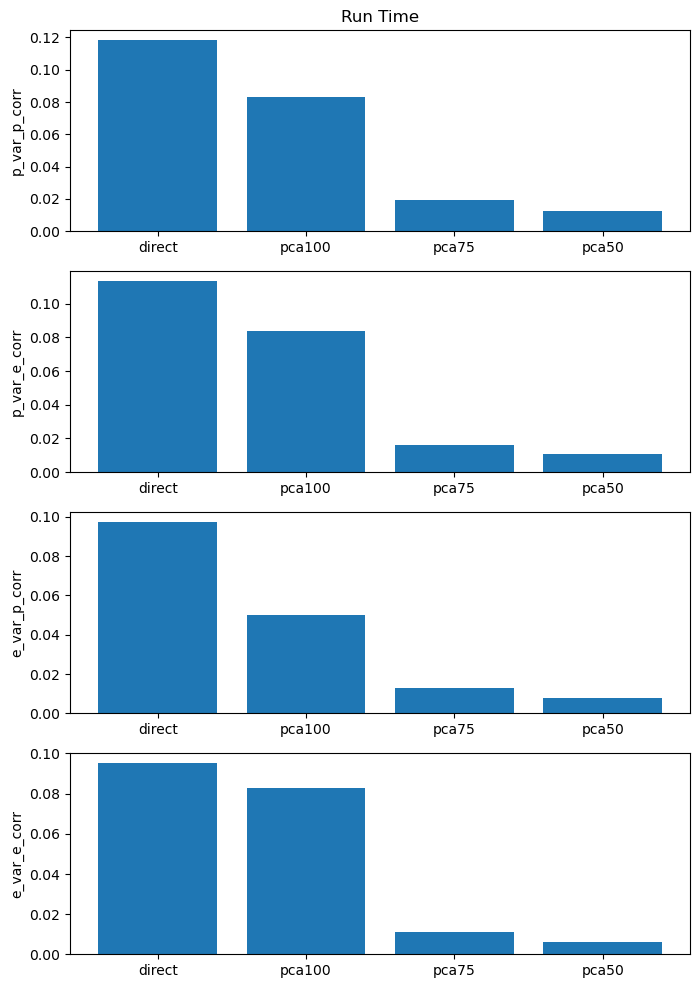

In [46]:
plt.figure()
fig, axes = plt.subplots(4, 1, figsize=(8, 12))
labels = ['direct', 'pca100', 'pca75', 'pca50']
cov_names = ['p_var_p_corr', 'p_var_e_corr', 'e_var_p_corr', 'e_var_e_corr']
for i in range(len(labels)):
    axes[i].bar(labels, [time_d[i], time_pca100[i], time_pca75[i], time_pca50[i]])
    axes[i].set_ylabel(cov_names[i])
axes[0].set_title('Run Time')
plt.show()